# FSRS online vs SuperMemo 18

[![open in colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-spaced-repetition/fsrs-vs-sm18/blob/main/compare_online.ipynb)

Here is a more fair comparison between FSRS and SM-18. 

In FSRS online, each repetition is only used once. The repetitions are sorted by the review date ascending. Then FSRS will make prediction one by one and update the model after each prediction. So FSRS online has zero knowledge of the future reviews as SM-18 does.

In [1]:
%pip install -q FSRS-Optimizer==4.11.0
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import mean_squared_error
from tqdm.auto import tqdm
from fsrs_optimizer import lineToTensor, collate_fn, power_forgetting_curve, plot_brier, FSRS, RevlogDataset, WeightClipper, Optimizer

tqdm.pandas()

revlogs = pd.read_csv('revlog_history.tsv', sep='\t', keep_default_na=False)
revlogs = revlogs[(revlogs['i'] > 1) & (revlogs['delta_t'] > 0) & (revlogs['t_history'].str.count(',0') == 0)].copy()

revlogs['tensor'] = revlogs.progress_apply(lambda x: lineToTensor(list(zip([x['t_history']], [x['r_history']]))[0]), axis=1)
revlogs.sort_values(by=['review_date'], inplace=True)
revlogs.reset_index(drop=True, inplace=True)

Note: you may need to restart the kernel to use updated packages.


  0%|          | 0/23720 [00:00<?, ?it/s]

In [2]:
model = FSRS([0.4, 0.6, 2.4, 5.8, 4.93, 0.94, 0.86, 0.01, 1.49, 0.14, 0.94, 2.18, 0.05, 0.34, 1.26, 0.29, 2.61])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(revlogs))
loss_fn = torch.nn.BCELoss(reduction='none')

dataset = RevlogDataset(revlogs)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
clipper = WeightClipper()
d = []
s = []
r = []

for batch in tqdm(dataloader):
    model.train()
    optimizer.zero_grad()
    sequences, delta_ts, labels, seq_lens = batch
    outputs, _ = model(sequences)
    stabilities, difficulties = outputs[seq_lens-1, 0].transpose(0, 1)
    d.append(difficulties.detach().numpy()[0])
    s.append(stabilities.detach().numpy()[0])
    retentions = power_forgetting_curve(delta_ts, stabilities)
    r.append(retentions.detach().numpy()[0])
    loss = loss_fn(retentions, labels).sum()
    loss.backward()
    optimizer.step()
    scheduler.step()
    model.apply(clipper)

revlogs['difficulty'] = d
revlogs['stability'] = s
revlogs['p'] = r

for name, param in model.named_parameters():
    print(f"{name}: {list(map(lambda x: round(float(x), 4),param))}")

  0%|          | 0/23720 [00:00<?, ?it/s]

w: [1.9548, 7.5586, 14.2023, 24.868, 3.6636, 2.4686, 0.5981, 0.0209, 1.8457, 0.4771, 1.2523, 2.3336, 0.1149, 0.296, 1.5895, 0.4505, 2.6303]


Loss of FSRS online: 0.3498
R-squared: -0.5180
RMSE: 0.0701
MAE: 0.0430
[0.48627342 0.4669467 ]


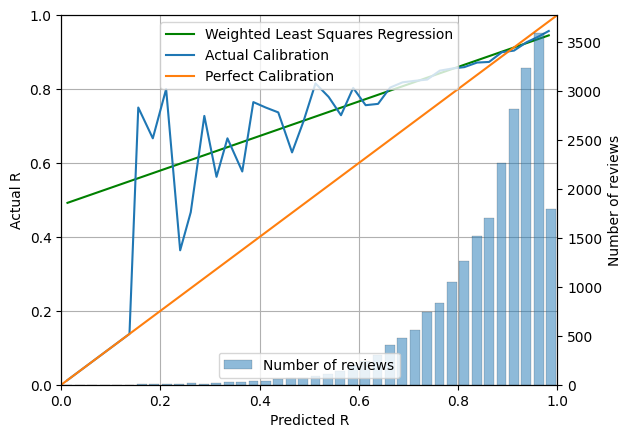

In [3]:
revlogs['log_loss'] = revlogs.apply(lambda row: - np.log(row['p']) if row['y'] == 1 else - np.log(1 - row['p']), axis=1)
log_loss = revlogs['log_loss'].mean()
print(f"Loss of FSRS online: {log_loss:.4f}")

fig0 = plt.figure()
fsrs_metrics = plot_brier(revlogs['p'], revlogs['y'], bins=40, ax=fig0.add_subplot(111))
fsrs_metrics['log_loss'] = log_loss
fig0.show()

Loss of SM-18: 0.3804
R-squared: -3.7305
RMSE: 0.1224
MAE: 0.0580
[0.63382944 0.29637188]
Universal Metric of FSRS: 0.0320
Universal Metric of SM18: 0.0380


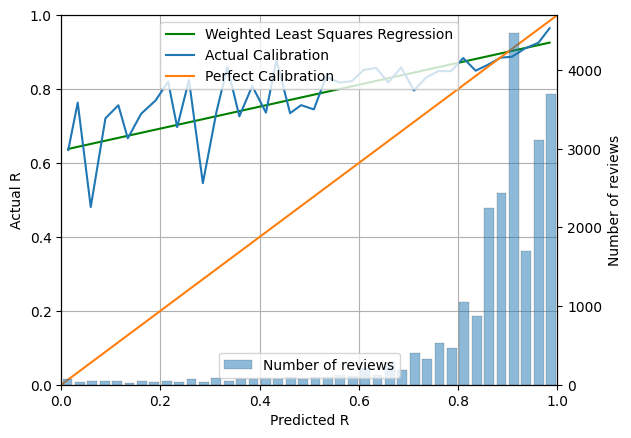

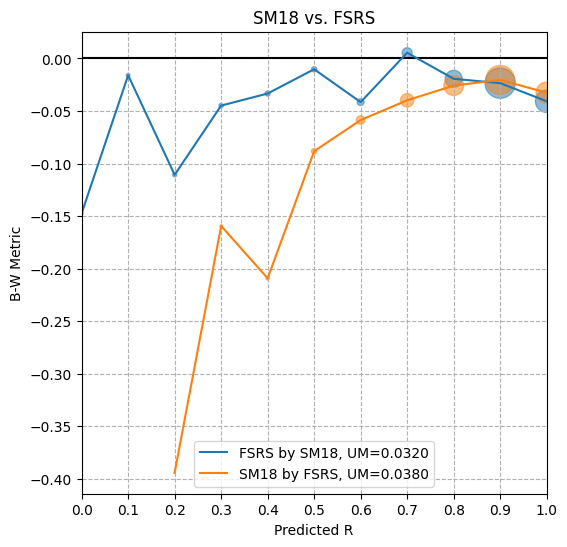

In [4]:
revlogs['sm18_p'] = 1 - revlogs['expFI'] / 100
revlogs['log_loss'] = revlogs.apply(lambda row: - np.log(row['sm18_p']) if row['y'] == 1 else - np.log(1 - row['sm18_p']), axis=1)
log_loss = revlogs['log_loss'].mean()
print(f"Loss of SM-18: {log_loss:.4f}")
cross_comparison = revlogs[['sm18_p', 'p', 'y']].copy()
fig1 = plt.figure()
sm18_metrics = plot_brier(cross_comparison['sm18_p'], cross_comparison['y'], bins=40, ax=fig1.add_subplot(111))
sm18_metrics['log_loss'] = log_loss
fig1.show()

fig2 = plt.figure(figsize=(6, 6))
ax = fig2.gca()

cross_comparison['SM18_B-W'] = cross_comparison['sm18_p'] - cross_comparison['y']
cross_comparison['SM18_Bin'] = cross_comparison['sm18_p'].map(lambda x: round(x, 1))
cross_comparison['FSRS_B-W'] = cross_comparison['p'] - cross_comparison['y']
cross_comparison['FSRS_bin'] = cross_comparison['p'].map(lambda x: round(x, 1))

ax.axhline(y = 0.0, color = 'black', linestyle = '-')

cross_comparison_group = cross_comparison.groupby(by='SM18_Bin').agg({'y': ['mean'], 'FSRS_B-W': ['mean'], 'p': ['mean', 'count']})
universal_metric = mean_squared_error(cross_comparison_group['y', 'mean'], cross_comparison_group['p', 'mean'], sample_weight=cross_comparison_group['p', 'count'], squared=False)
fsrs_metrics['universal_metric'] = universal_metric
print(f"Universal Metric of FSRS: {universal_metric:.4f}")
cross_comparison_group['p', 'percent'] = cross_comparison_group['p', 'count'] / cross_comparison_group['p', 'count'].sum()
ax.scatter(cross_comparison_group.index, cross_comparison_group['FSRS_B-W', 'mean'], s=cross_comparison_group['p', 'percent'] * 1024, alpha=0.5)
ax.plot(cross_comparison_group['FSRS_B-W', 'mean'], label=f'FSRS by SM18, UM={universal_metric:.4f}')

cross_comparison_group = cross_comparison.groupby(by='FSRS_bin').agg({'y': ['mean'], 'SM18_B-W': ['mean'], 'sm18_p': ['mean', 'count']})
universal_metric = mean_squared_error(cross_comparison_group['y', 'mean'], cross_comparison_group['sm18_p', 'mean'], sample_weight=cross_comparison_group['sm18_p', 'count'], squared=False)
sm18_metrics['universal_metric'] = universal_metric
print(f"Universal Metric of SM18: {universal_metric:.4f}")
cross_comparison_group['sm18_p', 'percent'] = cross_comparison_group['sm18_p', 'count'] / cross_comparison_group['sm18_p', 'count'].sum()
ax.scatter(cross_comparison_group.index, cross_comparison_group['SM18_B-W', 'mean'], s=cross_comparison_group['sm18_p', 'percent'] * 1024, alpha=0.5)
ax.plot(cross_comparison_group['SM18_B-W', 'mean'], label=f'SM18 by FSRS, UM={universal_metric:.4f}')

ax.legend(loc='lower center')
ax.grid(linestyle='--')
ax.set_title("SM18 vs. FSRS")
ax.set_xlabel('Predicted R')
ax.set_ylabel('B-W Metric')
ax.set_xlim(0, 1)
ax.set_xticks(np.arange(0, 1.1, 0.1))

fig2.show()

In [5]:
{
    'fsrs': fsrs_metrics,
    'sm18': sm18_metrics
}

{'fsrs': {'R-squared': -0.5179603798105978,
  'RMSE': 0.07009577070858619,
  'MAE': 0.04297064064387831,
  'log_loss': 0.34984414301802935,
  'universal_metric': 0.03201079658057356},
 'sm18': {'R-squared': -3.73046910364614,
  'RMSE': 0.12237209911008613,
  'MAE': 0.05802698145026137,
  'log_loss': 0.380448366647988,
  'universal_metric': 0.03799781317788354}}